# Описание проекта (Телеком)

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача проекта — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

**Оператор предоставляет два основных типа услуг:**
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).


**Также абонентам доступен ряд услуг:** 
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

**Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:**


* contract — информация о договорах;
* personal — персональные данные клиентов;
* internet — информация об интернет-услугах;
* phone — информация об услугах телефонии.

**Таблица telecom.contract**
*   customerID — ID абонента;
*   BeginDate — дата начала действия договора;
*   EndDate — дата окончания действия договора;
*   Type — тип оплаты: раз в год-два или ежемесячно;
*   PaperlessBilling — электронный расчётный лист;
*   PaymentMethod — тип платежа;
*   MonthlyCharges — расходы за месяц;
*   TotalCharges — общие расходы абонента.

**Таблица telecom.personal**
*   customerID — ID пользователя;
*   gender — пол;
*   SeniorCitizen — является ли абонент пенсионером;
*   Partner — есть ли у абонента супруг или супруга;
*   Dependents — есть ли у абонента дети.

**Таблица telecom.internet**
*   customerID — ID пользователя;
*   InternetService — тип подключения;
*   OnlineSecurity — блокировка опасных сайтов;
*   OnlineBackup — облачное хранилище файлов для резервного копирования данных;
*   DeviceProtection — антивирус;
*   TechSupport — выделенная линия технической поддержки;
*   StreamingTV — стриминговое телевидение;
*   StreamingMovies — каталог фильмов.

**Таблица telecom.phone**
*   customerID — ID пользователя;
*   MultipleLines — подключение телефона к нескольким линиям одновременно.

# 1. Загрузка данных

Устанавливаем необходимые библиотеки

In [1]:
# убираем вывод логов
#%%capture
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


Загружаем библиотеки согласно PEP-8

In [2]:
import datetime
import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, roc_curve, auc, accuracy_score,
    confusion_matrix, recall_score, average_precision_score
)

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import phik
from phik import resources, report


RANDOM_STATE = 131223

Подключаемся к базе данных

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
}

In [4]:
# форматируем строку и создаём переменную

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

Создание подключения

In [5]:
engine = create_engine(connection_string)

`Вывод:` мы описали проект и перечислили основную информацию о таблицах с которыми нам предстоит работать.

Установили и загрузили необходимые библиотеки, подключились к базе данных и создали подключение.

# 2. Предобработка данных и ИАД

Создаём функцию для выведения основной информаци о датасете

In [6]:
def show_info(data):

    '''Выводим на экран следущую информацию:

    - размер таблицы
    - инфо о таблице
    - пропуски
    - дубликаты
    - выводим случайную строку
    - первые 5 строк
    - суммарная статистика по числовым параметрам
    
    '''

    display('Размер таблицы: ', data.shape)
    display('Общая информация:',data.info())
    display('Пропуски:',data.isna().mean())
    display('Дубликаты:',data.duplicated().sum())
    display('Случайная строка:',data.sample(1))
    display('Первые 5 строк:',data.head())
    display('Описание:',data.describe())
    #display('Описание:',data.describe(include=['O']))

При помощи SQL подгружаем из базы PostGre информацию о договорах.

In [7]:
contract = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(contract, con=engine)
show_info(contract)

'Размер таблицы: '

(7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


'Общая информация:'

None

'Пропуски:'

customerID          0.000000
BeginDate           0.000000
EndDate             0.734630
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
dtype: float64

'Дубликаты:'

0

'Случайная строка:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3216,6016-LVTJQ,2019-07-07,None,Month-to-month,No,Mailed check,20.65,716.4


'Первые 5 строк:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


'Описание:'

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


При помощи SQL подгружаем из базы PostGre информацию персональных данных клиентов.

In [8]:
personal = '''
SELECT *
FROM telecom.personal;
'''
personal = pd.read_sql_query(personal, con=engine)
show_info(personal)

'Размер таблицы: '

(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'Общая информация:'

None

'Пропуски:'

customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

'Дубликаты:'

0

'Случайная строка:'

,customerID,gender,SeniorCitizen,Partner,Dependents
2651,4873-ILOLJ,Male,0,No,No


'Первые 5 строк:'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'Описание:'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


При помощи SQL подгружаем из базы PostGre информацию об интернет-услугах.

In [9]:
internet = '''
SELECT *
FROM telecom.internet;
'''
internet = pd.read_sql_query(internet, con=engine)
show_info(internet)

'Размер таблицы: '

(5518, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


'Общая информация:'

None

'Пропуски:'

c1    0.0
c2    0.0
c3    0.0
c4    0.0
c5    0.0
c6    0.0
c7    0.0
c8    0.0
dtype: float64

'Дубликаты:'

0

'Случайная строка:'

,c1,c2,c3,c4,c5,c6,c7,c8
2407,5762-TJXGK,DSL,Yes,Yes,Yes,No,Yes,Yes


'Первые 5 строк:'

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


'Описание:'

,c1,c2,c3,c4,c5,c6,c7,c8
count,5518,5518,5518,5518,5518,5518,5518,5518
unique,5518,3,3,3,3,3,3,3
top,customerID,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


При помощи SQL подгружаем из базы PostGre информацию об услугах телефонии.

In [10]:
phone = '''
SELECT *
FROM telecom.phone;
'''
phone = pd.read_sql_query(phone, con=engine)
show_info(phone)

'Размер таблицы: '

(6362, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'Общая информация:'

None

'Пропуски:'

c1    0.0
c2    0.0
dtype: float64

'Дубликаты:'

0

'Случайная строка:'

,c1,c2
668,1307-TVUFB,Yes


'Первые 5 строк:'

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


'Описание:'

,c1,c2
count,6362,6362
unique,6362,3
top,customerID,No
freq,1,3390


`Вывод:` в результате предобработки и загрузки данных и из базы данных PostGre мы создали следующие датафреймы:
'contract'
'personal'
'internet'
'phone'
В таблицах не обнаружено дубликатов.
Пропуски обнаружены в таблице contract в параметре EndDate и с большим отрывом в TotalCharges (73% и 0,1% соответственно)
В таблицах internet и phone, названия признаков смещены на первую строку. Названия призников выболнено с использованием как строчных, так и прописных букв, желательно привести шрифт к единообразию.

## 2.1 Предобработка

Приводим шрифт признаков contract к snake case

In [11]:
contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN


In [12]:
contract.columns = contract.columns.str.lower()

In [13]:
contract.head(1)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN


Приводим шрифт признаков personal к snake case

In [14]:
personal.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [15]:
personal.columns = personal.columns.str.lower()

In [16]:
personal.head(1)

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


Меняем названия признаков в таблице internet на корректные.

In [17]:
internet.head(1)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [18]:
# записываем значения строки с индексом 0 в название признаков
internet.columns = internet.loc[0]

# приводим все названия признаков к строчному шрифту
internet.columns = internet.columns.str.lower()

# делаем ресет индексов
internet = internet.drop(index=[0], axis=1).reset_index(drop=True)

In [19]:
internet.head(1)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


Меняем названия признаков в таблице phone на корректные.

In [20]:
phone.head(1)

,c1,c2
0,customerID,MultipleLines


In [21]:
# записываем значения строки с индексом 0 в название признаков
phone.columns = phone.loc[0]

# приводим все названия признаков к строчному шрифту
phone.columns = phone.columns.str.lower()

# делаем ресет индексов
phone = phone.drop(index=[0], axis=1).reset_index(drop=True)

In [22]:
phone.head(1)

,customerid,multiplelines
0,5575-GNVDE,No


Заполнение пропусков

In [23]:
# кол-во прокусков
contract['enddate'].isna().sum()

5174

In [24]:
# уникальные значения
contract['enddate'].unique()

array([None, datetime.date(2019, 12, 1), datetime.date(2019, 11, 1),
       datetime.date(2019, 10, 1), datetime.date(2020, 1, 1)],
      dtype=object)

Предположим, что пропуски в колонке enddate означают, что контракт не завершён, а продалжает действовать. Поэтому, предлагаю, заменить пропуски строчным значением 'valid_contract'

In [25]:
contract['enddate'] = contract['enddate'].fillna('valid_contract')

In [26]:
display(contract.isna().sum())

customerid           0
begindate            0
enddate              0
type                 0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
dtype: int64

Пропуски в totalcharges, скорее всего, означают, отсутствие начислений, поэтому, заполним эти пропущенные значения нулями.

In [27]:
contract['totalcharges'] = contract['totalcharges'].fillna(0)

In [28]:
display(contract.isna().sum())

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

`Вывод:` навания параметров приведены к единому написанию (snake case) отсутсвующие названия параметров были введены из певой строки таблицы.

## 2.2 Объединение таблиц

Обединим преобработанные таблицы в одну таблицу

In [29]:
merged_personal = personal.merge(contract, on='customerid', how='inner')
merged_df = merged_personal.merge(internet, on='customerid', how='outer')
final_df = merged_df.merge(phone, on='customerid', how='outer')

Выводим результат

In [30]:
# выводим размеры новых таблиц
print(merged_personal.shape)
print(merged_df.shape)
print(final_df.shape)

(7043, 12)
(7043, 19)
(7043, 20)


In [31]:
# выводим 5 сторк новой таблицы
final_df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,valid_contract,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,valid_contract,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,valid_contract,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


Выводим основную информацию о новой финальной таблице используя ранее созданную функцию show_info()

In [32]:
show_info(final_df)

'Размер таблицы: '

(7043, 20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   begindate         7043 non-null   object 
 6   enddate           7043 non-null   object 
 7   type              7043 non-null   object 
 8   paperlessbilling  7043 non-null   object 
 9   paymentmethod     7043 non-null   object 
 10  monthlycharges    7043 non-null   float64
 11  totalcharges      7043 non-null   float64
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


'Общая информация:'

None

'Пропуски:'

customerid          0.000000
gender              0.000000
seniorcitizen       0.000000
partner             0.000000
dependents          0.000000
begindate           0.000000
enddate             0.000000
type                0.000000
paperlessbilling    0.000000
paymentmethod       0.000000
monthlycharges      0.000000
totalcharges        0.000000
internetservice     0.216669
onlinesecurity      0.216669
onlinebackup        0.216669
deviceprotection    0.216669
techsupport         0.216669
streamingtv         0.216669
streamingmovies     0.216669
multiplelines       0.096834
dtype: float64

'Дубликаты:'

0

'Случайная строка:'

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
1319,1725-MIMXW,Male,0,No,Yes,2019-03-18,2020-01-01,Month-to-month,Yes,Mailed check,19.45,19.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


'Первые 5 строк:'

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,valid_contract,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,valid_contract,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,valid_contract,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


'Описание:'

,seniorcitizen,monthlycharges,totalcharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,64.761692,2279.734304
std,0.368612,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,0.000000,35.500000,398.550000
50%,0.000000,70.350000,1394.550000
75%,0.000000,89.850000,3786.600000
max,1.000000,118.750000,8684.800000


Конвертируем 'seniorcitizen' в категориальное значение

In [33]:
# Коныертируем 'seniorcitizen' в категориальное значение
final_df['seniorcitizen'] = final_df['seniorcitizen'].astype('category')

# выводим новый датафрем
print(final_df.dtypes)

customerid            object
gender                object
seniorcitizen       category
partner               object
dependents            object
begindate             object
enddate               object
type                  object
paperlessbilling      object
paymentmethod         object
monthlycharges       float64
totalcharges         float64
internetservice       object
onlinesecurity        object
onlinebackup          object
deviceprotection      object
techsupport           object
streamingtv           object
streamingmovies       object
multiplelines         object
dtype: object


`Вывод:` мы видим, что в финальной таблице есть пропуски в восьми признаках. Дубликвтов нет.

Убираем пропуски

In [34]:
# высчитываем среднее кол-во пропущенных значений для каждой колонки
nan_means = final_df.isna().mean()

# фильтруем значения больше нуля
nan_columns = list(nan_means[nan_means > 0].index)

# заполняем пропуски строкой No
for column in nan_columns:
    final_df[column] = final_df[column].fillna('No')

In [35]:
nan_means

customerid          0.000000
gender              0.000000
seniorcitizen       0.000000
partner             0.000000
dependents          0.000000
begindate           0.000000
enddate             0.000000
type                0.000000
paperlessbilling    0.000000
paymentmethod       0.000000
monthlycharges      0.000000
totalcharges        0.000000
internetservice     0.216669
onlinesecurity      0.216669
onlinebackup        0.216669
deviceprotection    0.216669
techsupport         0.216669
streamingtv         0.216669
streamingmovies     0.216669
multiplelines       0.096834
dtype: float64

In [36]:
final_df.isna().mean()

customerid          0.0
gender              0.0
seniorcitizen       0.0
partner             0.0
dependents          0.0
begindate           0.0
enddate             0.0
type                0.0
paperlessbilling    0.0
paymentmethod       0.0
monthlycharges      0.0
totalcharges        0.0
internetservice     0.0
onlinesecurity      0.0
onlinebackup        0.0
deviceprotection    0.0
techsupport         0.0
streamingtv         0.0
streamingmovies     0.0
multiplelines       0.0
dtype: float64

`Вывод:` пропусков нет

Создаём целевой признак

In [37]:
final_df['target'] = final_df['enddate'].apply(lambda x: 0 if x == 'valid_contract' else 1)

Создаём новые признаки

In [38]:
# создаём признак говорящий о том что абонент пользуется обеими услугами: интернетом и телефоном одновременно

final_df['internet+phone'] = ((final_df['internetservice'] != 'No') & (final_df['multiplelines'] != 'No')).map({True: 'Yes', False: 'No'})

In [39]:
# сохраняем в переменную все виды доступных услуг

services = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']

In [40]:
# создаём признак с количеством используемых (подключённых) услуг.

final_df['services_summary'] = final_df[services].applymap(lambda x: 1 if x == 'Yes' else 0).sum(axis=1)

Создаём график соотношения признаков и целевого признака.

In [41]:
def graph(final_df, feature, figsize=(12, 6), palette='pastel', margin=(0.001, 0.001)):
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    
    ax = sns.countplot(x=feature, hue='target', data=final_df, palette=palette)
    total = len(final_df)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}\n({height/total:.2%})', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')    

    plt.subplots_adjust(bottom=margin[0], top=1 - margin[1])
        
    plt.title(f'Соотношение ушедших и оставшихся клиентов для признака: {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Target', labels=['Ушедшие', 'Оставшиеся'])
    plt.show()

#### Выведем графики и посмотрим на соотношения

##### type: тип оплаты, ежемесячно, либо раз или два раза в год

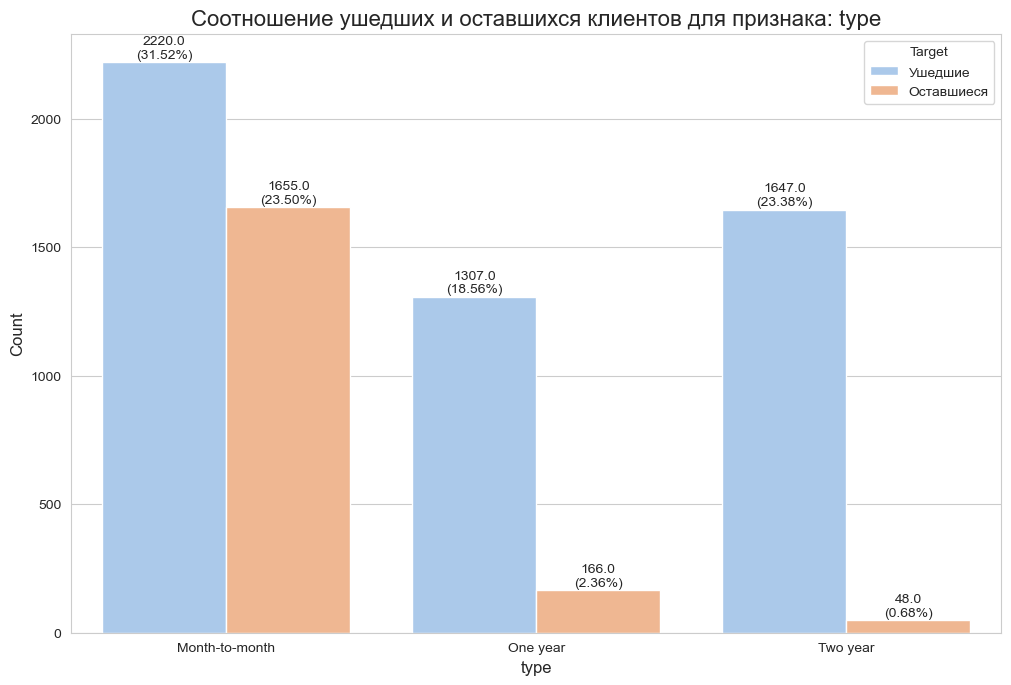

In [42]:
graph(final_df, 'type')

`Вывод:` Те, кто платит за услуги связи раз в год или два  имеют тенденциюбыть более лояльными клиентами и реже отказываются от услуг оперетора, нежли ежемесячные плетельцики.

##### Partner — есть ли у абонента супруг или супруга

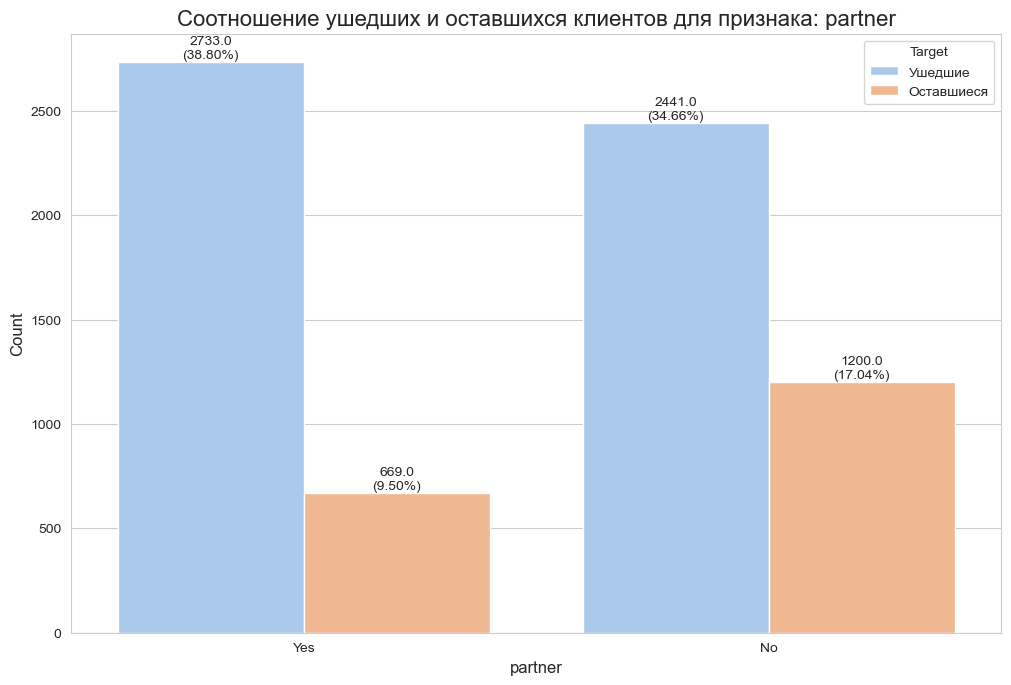

In [43]:
graph(final_df, 'partner')

`Вывод:` Наличие супруга положительно влияет на лояльность аббонента

##### PaymentMethod — тип платежа

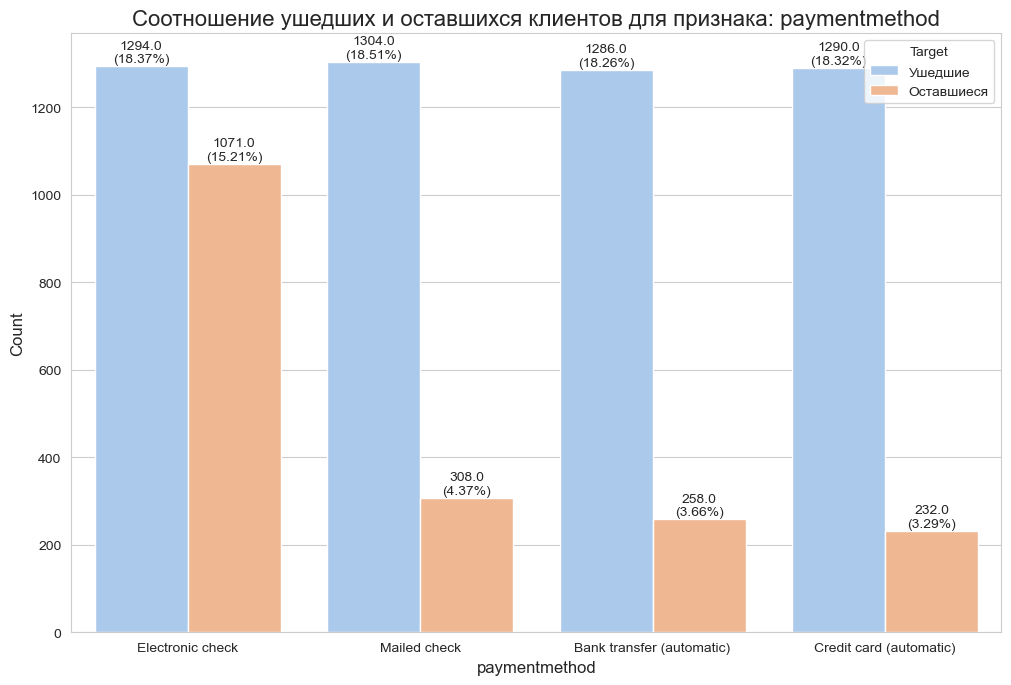

In [44]:
graph(final_df, 'paymentmethod')

`Вывод:` Аббоненты плятящие при помощи электрнонных чеков имеют кратно больший шанс уйти

##### Наличие обоих услуг одновременно internet+phone

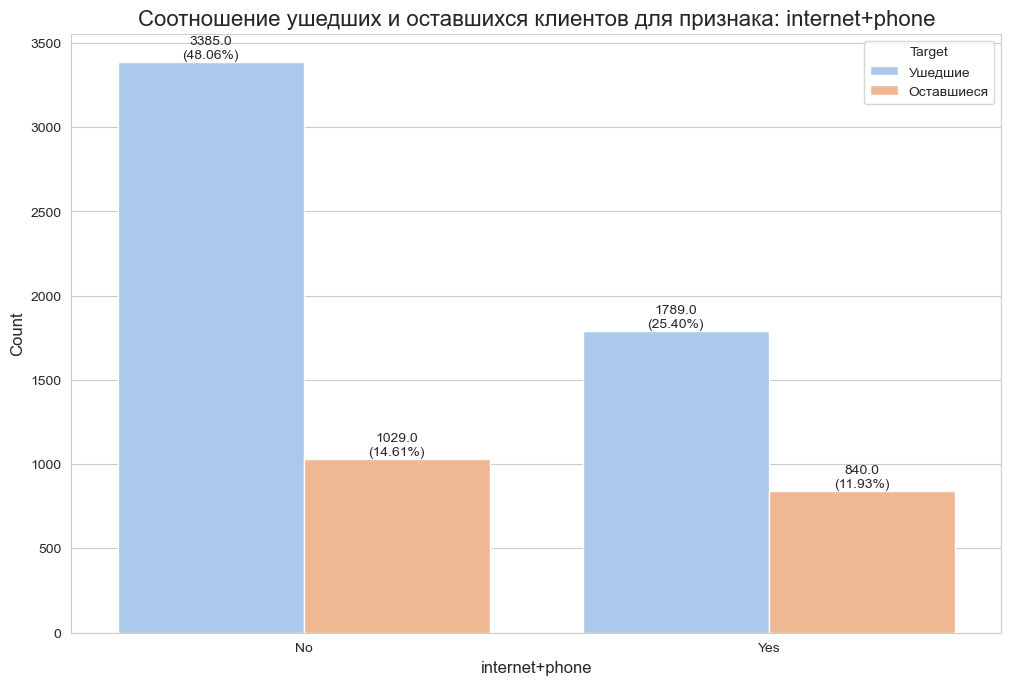

In [45]:
graph(final_df, 'internet+phone')

`Вывод:` Сильно заметной разницы между наличием одновременно двух услуг (интернет+ телефон) не прослеживается, однако имеется лёгкий перевес в сторону тех у кого нет одновременно услуги интернета и телефона, эти абоненты в целом, более лояльны.

##### Кол-во услуг services_summary

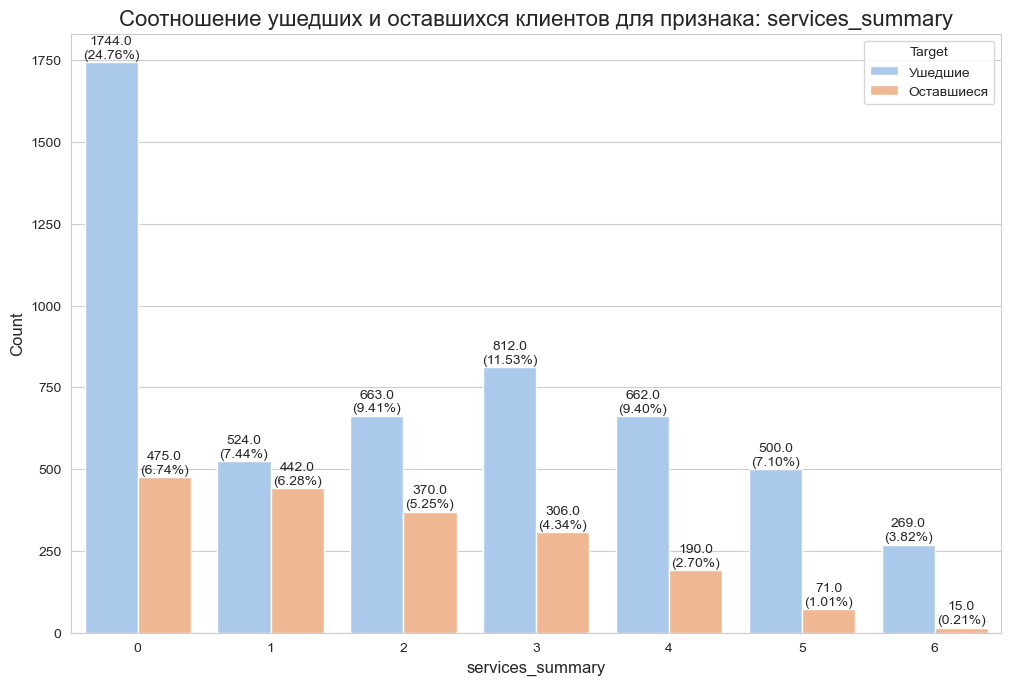

In [46]:
graph(final_df, 'services_summary')

`Вывод:` Интересный факт, максимально лояльны те клиенты, у которых не подлючено ни одной доп услуги. Меньше шансов разочароваться в провайдере.

##### MultipleLines — подключение телефона к нескольким линиям одновременно.

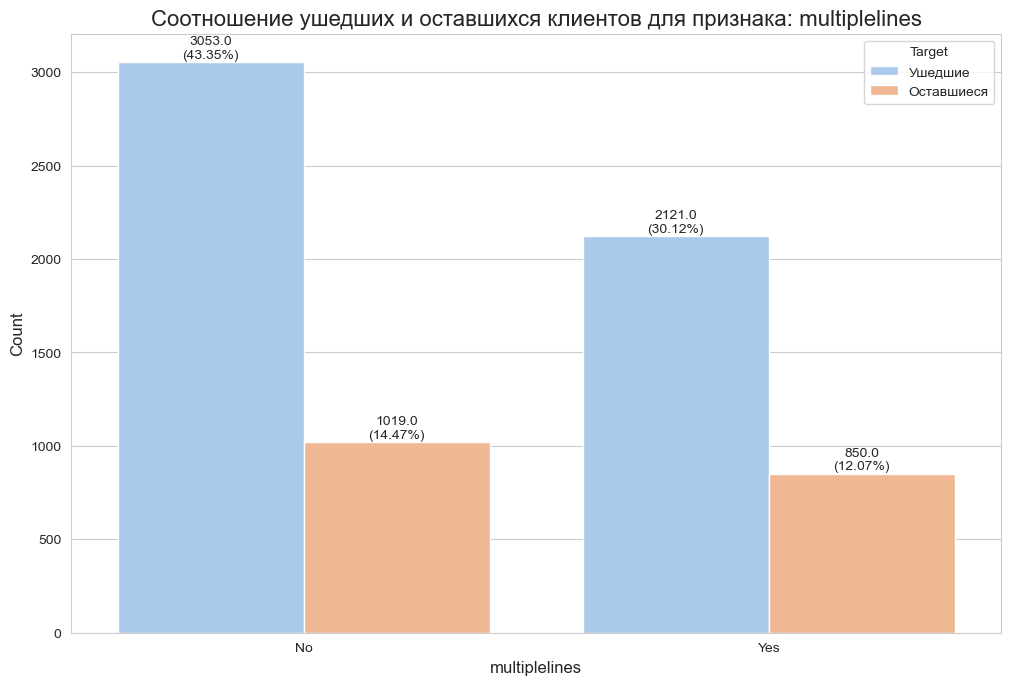

In [47]:
graph(final_df, 'multiplelines')

`Вывод:` Подключение только к одной линии является признаком большейлояльности клиента

##### TechSupport — выделенная линия технической поддержки

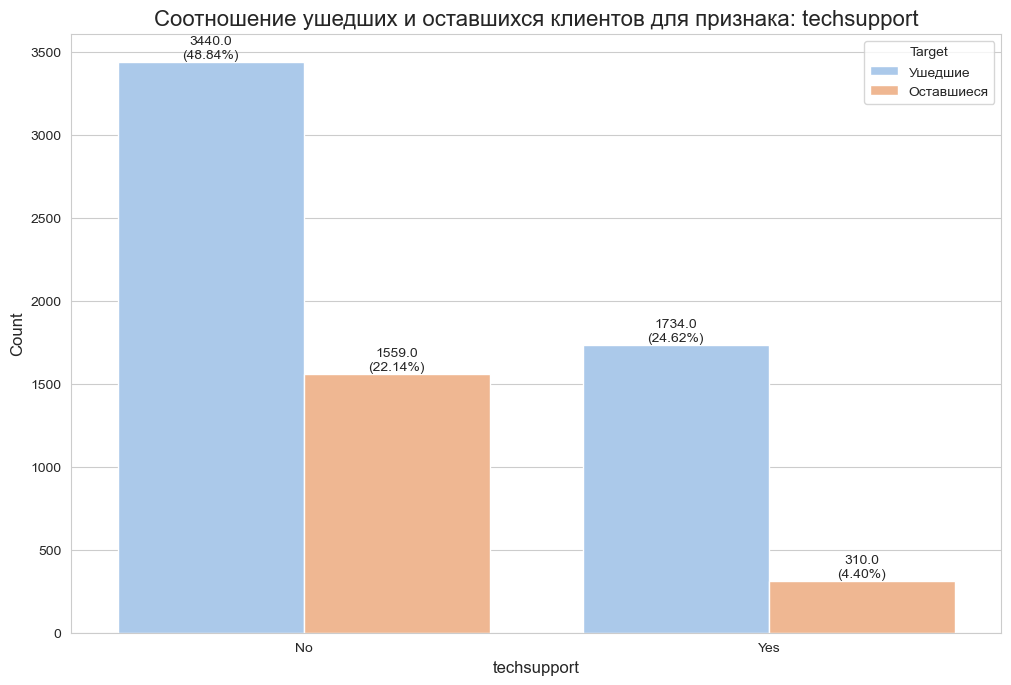

In [48]:
graph(final_df, 'techsupport')

`Вывод:` выделенная линия технической поддержки по-видимому, действует на разгневанных клиентов успокаивающе и делает их более лояльными. 

#### Корелляционный анализ

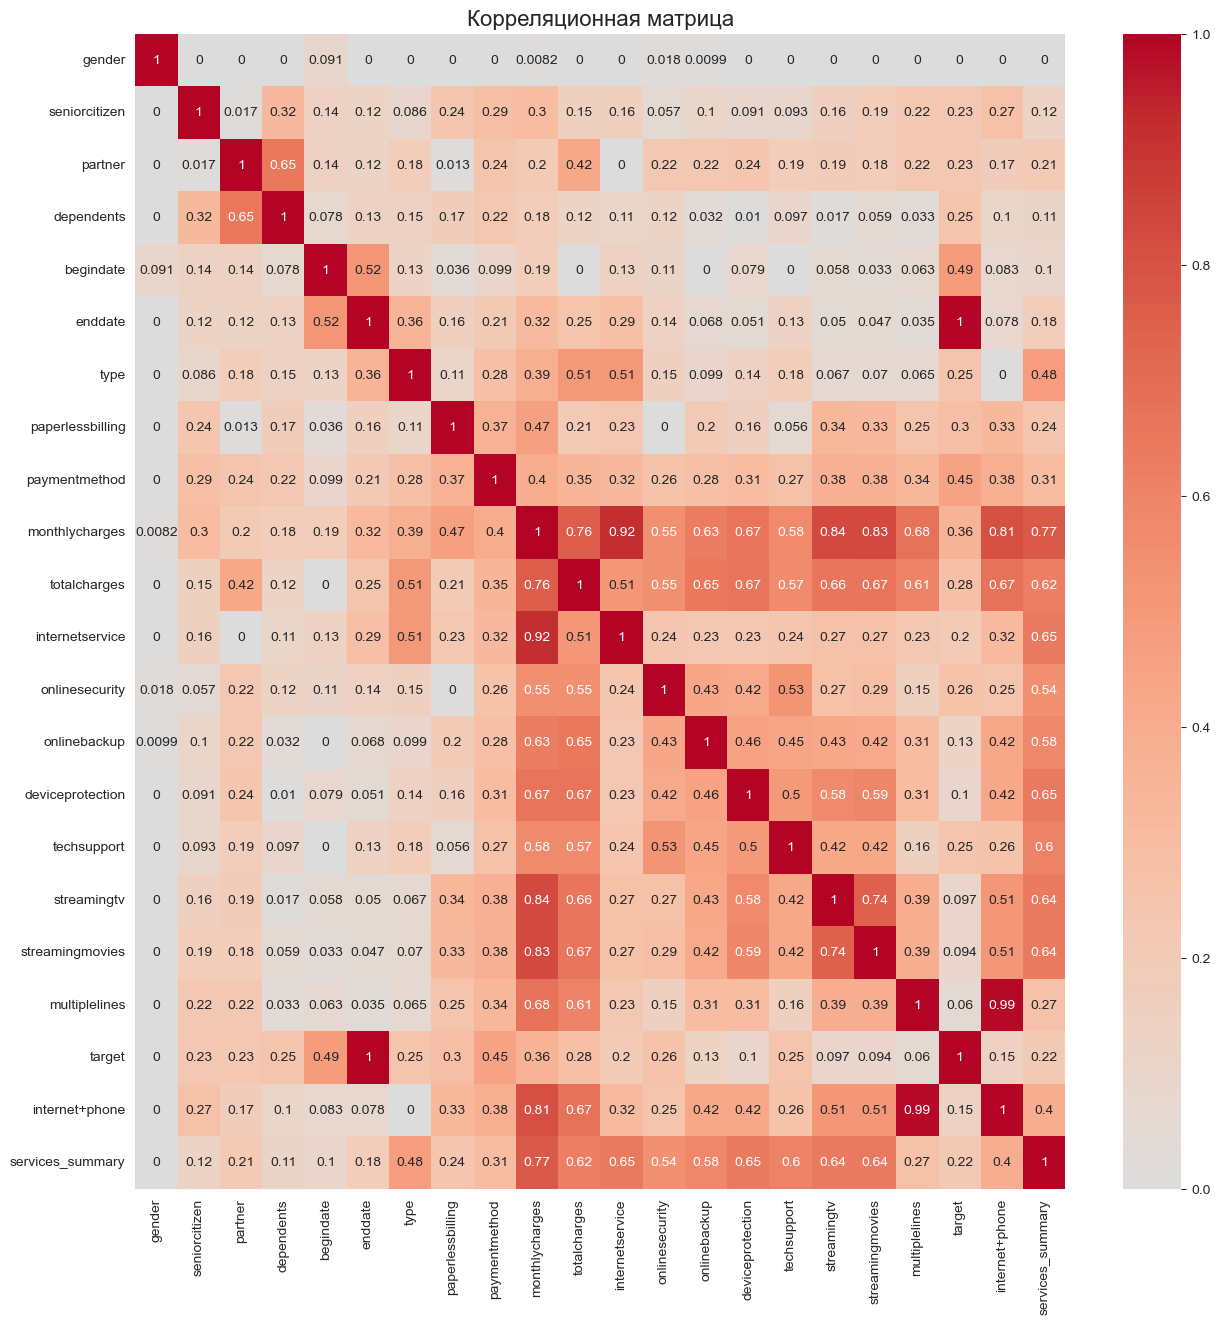

In [49]:
# передаём список непрерывных признаков
interval_cols = ['seniorcitizen', 'monthlycharges', 'totalcharges', 'target', 'services_summary']

# убираем customerid
final_df2 = final_df.drop('customerid', axis=1)

# создаём корреляционную матрицу Phik
correlation_matrix = final_df2.phik_matrix(interval_cols=interval_cols)

# устанавливаем размер графика
plt.figure(figsize=(15, 15))

# выбираем расцветку и центровку матрицы
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# название матрицы
plt.title('Корреляционная матрица', fontsize=16)

# вывод матрицы
plt.show()

`Вывод:` 

- Сильная корреляция:

 MonthlyCharges / InternetService - 0.92 

 StreamingTV / MonthlyCharges -  0,84

 StreamingMovies / MonthlyCharges - 0.83
 
 и другие.

- Слабая корреляция:
gender - имеет наименьшую корреляцию с остальными признаками, те не влиеят наних

## 2.3 Подготовка данных для обучения

Выбираем признаки для обучения модели исходя и данных полученым из марицы.

In [50]:
final_df = final_df[[ 
  'seniorcitizen', 
  'partner', 
  'dependents',
  'type', 
  'paperlessbilling', 
  'paymentmethod',  
  'monthlycharges', 
  'totalcharges', 
  'internetservice', 
  'onlinesecurity',
  'onlinebackup', 
  'deviceprotection', 
  'techsupport', 
  'streamingtv',
  'streamingmovies', 
  'multiplelines',
  'internet+phone', 
  'target', 
  'services_summary'
  ]]

Проверяем на дубликаты

In [51]:
final_df.duplicated().sum()

41

Убираем дубликаты

In [52]:
final_df = final_df.drop_duplicates()

Проверяем. Дубликаты убраны

In [53]:
final_df.duplicated().sum()

0

Выведем информацию о новой таблице

In [54]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7002 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   seniorcitizen     7002 non-null   category
 1   partner           7002 non-null   object  
 2   dependents        7002 non-null   object  
 3   type              7002 non-null   object  
 4   paperlessbilling  7002 non-null   object  
 5   paymentmethod     7002 non-null   object  
 6   monthlycharges    7002 non-null   float64 
 7   totalcharges      7002 non-null   float64 
 8   internetservice   7002 non-null   object  
 9   onlinesecurity    7002 non-null   object  
 10  onlinebackup      7002 non-null   object  
 11  deviceprotection  7002 non-null   object  
 12  techsupport       7002 non-null   object  
 13  streamingtv       7002 non-null   object  
 14  streamingmovies   7002 non-null   object  
 15  multiplelines     7002 non-null   object  
 16  internet+phone    7002 n

Проверяем дисбаланс классов

In [55]:
final_df['target'].value_counts(normalize=True)

0    0.736218
1    0.263782
Name: target, dtype: float64

`Вывод:` дисбаланс классов есть

### Разделяем данные на тренировочную и тестовую выборки

In [56]:
# делим данные на целевые и нелелевые выборки

features = final_df.drop('target', axis=1)
target = final_df['target']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, stratify = target, random_state = RANDOM_STATE)

In [58]:
# выводим размеры полученых выборок

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5251, 18) (5251,)
(1751, 18) (1751,)


Избавляемся от дисбаланса классов и масштабируем цифровые значения

In [59]:
cat_features = x_train.select_dtypes(include='object').columns.to_list()
num_features = x_train.select_dtypes(exclude='object').columns.to_list()

In [60]:
data_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), num_features),
                            ('ohe', OneHotEncoder(sparse=False, drop='first',), cat_features)],
                                remainder="drop")

In [61]:
data_transformer.fit(x_train)
features_train_transformed = data_transformer.transform(x_train)
features_test_transformed = data_transformer.transform(x_test)

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


`Вывод:` выборки разделены и проведено масштабирование данных. Данные готовы к обучению

# 3. Обучение моделей

Мы будем использовать несколько моделей машинного обучения для предсказания оттока клиентов телефонии.

Применим следущие модели для обучения:

- Random Forest
- CatBoost
- Нейросеть

В качестве метрики качества мы будем испотзовать ROC-AUC

### Random Forest

In [62]:
# Задаем сетку параметров для поиска
param_grid = {
    'n_estimators': [2, 5, 10],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 6]
}

In [63]:
# Инициализируем RandomForestClassifier с установленным seed для воспроизводимости результатов
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# Создаем объект GridSearchCV для поиска по сетке параметров
grid_search_rfc = GridSearchCV(
    rfc, 
    param_grid, 
    scoring='roc_auc', 
    cv=StratifiedKFold(n_splits=5), 
    verbose=1, 
    n_jobs=-1
)

# Обучаем модель на тренировочных данных
grid_search_rfc.fit(features_train_transformed, y_train)

# Выводим лучшие параметры и ROC-AUC на кросс-валидации
print("Лучшие параметры RandomForestClassifier: ", grid_search_rfc.best_params_)
print("Лучший ROC-AUC RandomForestClassifier на кросс-валидации: ", grid_search_rfc.best_score_)

# Сохраняем лучший результат ROC-AUC на тренировочных данных
best_roc_auc_rfc = grid_search_rfc.best_score_
print(f"Лучший ROC-AUC RandomForestClassifier на train: {best_roc_auc_rfc:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Лучшие параметры RandomForestClassifier:  {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 10}
Лучший ROC-AUC RandomForestClassifier на кросс-валидации:  0.8220834727622132
Лучший ROC-AUC RandomForestClassifier на train: 0.8221


`Вывод:` Random Forest на кросс валидации показал ROC-AUC: 0.8220

### CatBoost

In [64]:
cat_features
cat_features = ['partner', 'dependents', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines', 'internet+phone', 'seniorcitizen']


In [65]:
# диапазоны поиска для настройки гиперпараметров
param_grid_cb = {
    'iterations':  [100, 150],
    'depth': [5, 10],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [1, 5],
    'border_count': [32, 64],
}

# Инициализация CatBoostClassifier
cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=2, cat_features=cat_features)

# Создание объекта GridSearchCV для настройки гиперпараметров
grid_search_cb = GridSearchCV(
    cb,
    param_grid_cb,
    scoring='roc_auc',
    cv=10,
    verbose=1,
    n_jobs=-1
)

# Обучение модели CatBoost на тренировочных данных
grid_search_cb.fit(x_train, np.array(y_train))  

# Вывод лучших параметров и ROC-AUC на кросс-валидации
print("Лучшие параметры CatBoost: ", grid_search_cb.best_params_)
print("Лучший ROC-AUC CatBoost на кросс-валидации: ", grid_search_cb.best_score_)

# Сохранение лучшего ROC-AUC на тренировочных данных
best_roc_auc_cb = grid_search_cb.best_score_
print(f"Лучший ROC-AUC CatBoostClassifier на train: {best_roc_auc_cb:.4f}")

Fitting 10 folds for each of 32 candidates, totalling 320 fits


0:	learn: 0.6749154	total: 71.3ms	remaining: 10.6s
2:	learn: 0.6428760	total: 96.8ms	remaining: 4.74s
4:	learn: 0.6175937	total: 131ms	remaining: 3.79s
6:	learn: 0.5949111	total: 166ms	remaining: 3.39s
8:	learn: 0.5747596	total: 199ms	remaining: 3.11s
10:	learn: 0.5583689	total: 227ms	remaining: 2.87s
12:	learn: 0.5415717	total: 254ms	remaining: 2.68s
14:	learn: 0.5274875	total: 282ms	remaining: 2.54s
16:	learn: 0.5151207	total: 316ms	remaining: 2.48s
18:	learn: 0.5041098	total: 361ms	remaining: 2.49s
20:	learn: 0.4944278	total: 404ms	remaining: 2.48s
22:	learn: 0.4870280	total: 425ms	remaining: 2.35s
24:	learn: 0.4794564	total: 457ms	remaining: 2.28s
26:	learn: 0.4728024	total: 486ms	remaining: 2.21s
28:	learn: 0.4669724	total: 533ms	remaining: 2.22s
30:	learn: 0.4620004	total: 566ms	remaining: 2.17s
32:	learn: 0.4571316	total: 597ms	remaining: 2.12s
34:	learn: 0.4531423	total: 711ms	remaining: 2.34s
36:	learn: 0.4493540	total: 793ms	remaining: 2.42s
38:	learn: 0.4457446	total: 844ms	

`Вывод:` CatBoost на кроссвалидации показал ROC-AUC: 0.8445

### Нейронная сеть

In [66]:
# Выводим размерность тренировочных данных
#print(X_train.shape)

class CustomEarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [67]:
#Задаем количество фолдов для кросс-валидации
n_splits = 5

# Списки для хранения оценок ROC-AUC на тестовых данных
roc_auc_scores = []

# Разделение на фолды
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Преобразуем признаки в тензоры
X_train_tens = torch.FloatTensor(features_train_transformed)
X_test_tens = torch.FloatTensor(features_test_transformed)
y_train_tens = torch.FloatTensor(np.array(y_train)).unsqueeze(1)
y_test_test = torch.FloatTensor(np.array(y_test)).unsqueeze(1)

for fold, (train_index, test_index) in enumerate(skf.split(X_train_tens, y_train_tens)):
    X_train_fold, X_test_fold = X_train_tens[train_index], X_train_tens[test_index]
    y_train_fold, y_test_fold = y_train_tens[train_index], y_train_tens[test_index]

    n_in_neurons = X_train_fold.shape[1]
    n_hidden_neurons_1 = 24
    n_hidden_neurons_2 = 1
    n_out_neurons = 1

    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss = nn.BCEWithLogitsLoss()

    early_stopping = CustomEarlyStopping(patience=5, min_delta=20)
    start_time_ns = time.time()
    num_epochs = 1000
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        preds = net.forward(X_train_fold)
        loss_value = loss(preds, y_train_fold)
        loss_value.backward()
        optimizer.step()

        if epoch % 5 == 0:
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test_fold)
                roc_auc = roc_auc_score(y_test_fold, test_preds)
                early_stopping(loss_value.item())
                if early_stopping.counter == 0:
                    best_roc = roc_auc
                print(f"Фолд {fold}, эпоха:{epoch}, ROC-AUC test: {roc_auc}")

                if early_stopping.early_stop:
                    print('Ранняя остановка!')
                    print(f'Лучший ROC-AUC нейросети на train: {best_roc:.4f}')
                    break 

    roc_auc_scores.append(best_roc)

# Выведем среднее значение и стандартное отклонение ROC-AUC для всех фолдов
print(f'Средний ROC-AUC на кросс-валидации: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores):.4f})')

Фолд 0, эпоха:0, ROC-AUC test: 0.3994020466608831
INFO: Early stopping counter 1 of 5
Фолд 0, эпоха:5, ROC-AUC test: 0.4596358174982975
INFO: Early stopping counter 2 of 5
Фолд 0, эпоха:10, ROC-AUC test: 0.5189227511450666
INFO: Early stopping counter 3 of 5
Фолд 0, эпоха:15, ROC-AUC test: 0.5444127277306692
INFO: Early stopping counter 4 of 5
Фолд 0, эпоха:20, ROC-AUC test: 0.551497681881361
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Фолд 0, эпоха:25, ROC-AUC test: 0.5438017145682329
Ранняя остановка!
Лучший ROC-AUC нейросети на train: 0.3994
Фолд 1, эпоха:0, ROC-AUC test: 0.6016831604560038
INFO: Early stopping counter 1 of 5
Фолд 1, эпоха:5, ROC-AUC test: 0.6654508432148178
INFO: Early stopping counter 2 of 5
Фолд 1, эпоха:10, ROC-AUC test: 0.7070674992177319
INFO: Early stopping counter 3 of 5
Фолд 1, эпоха:15, ROC-AUC test: 0.7293679741828218
INFO: Early stopping counter 4 of 5
Фолд 1, эпоха:20, ROC-AUC test: 0.7437570345739091
INFO: Early stopping counter 5 of 5
INF

`Вывод:` нейросеть показала ROC-AUC: 0.5316

`Общий вывод:` самая лучшая метрика ROC_AUC достигнута при использовании модели CatBoost с показателем метрики: 0.8491

# 4. Тестирование лучшей модели

### Сохраняем лучшие параметры в переменные

In [68]:
best_cb = CatBoostClassifier(**grid_search_cb.best_params_, random_state=RANDOM_STATE, verbose=0)
best_cb.fit(pd.DataFrame(features_train_transformed), np.array(y_train))

### Применяем лучшие параметры на тестовой модели

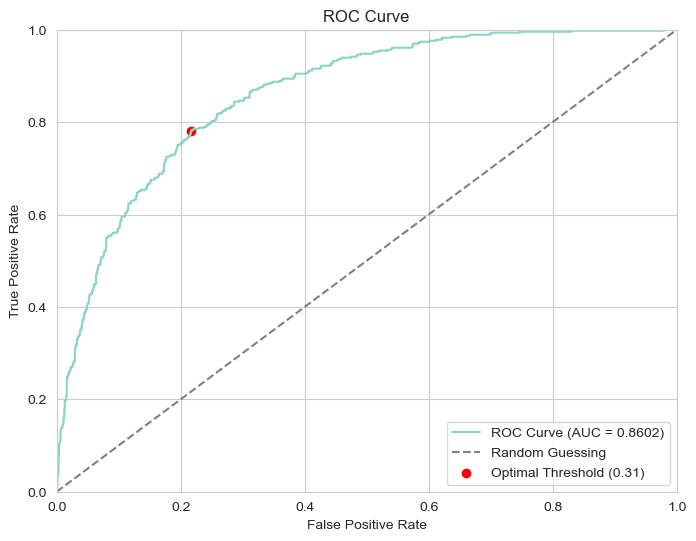

In [69]:
probs = best_cb.predict_proba(features_test_transformed)[:, 1]
preds = best_cb.predict(features_test_transformed)

fpr, tpr, thresholds = roc_curve(np.array(y_test), probs)
roc_auc = auc(fpr, tpr)

# находим оптимальный порог
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))

# выводим ROC кривую
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# отмечаем оптимальную пороговую точку на кривой ROC
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



`Вывод:` итоговоре значение метрики ROC-AUC соответствует целевой: 0,8602

### Для интерпритируемости модели, дополнительно, выводим метрику (accuracy)

In [70]:
accuracy_score(y_test, preds)

0.8206739006282124

`Вывод:` accuracy: 0.82

Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству.

Применительно к нашему предмету исследования, это означает что моддель проедсказывает одинакоко хорошо (0.82) лояльных и нелояльных клиентов. 

## Матрица ошибок лучшей модели

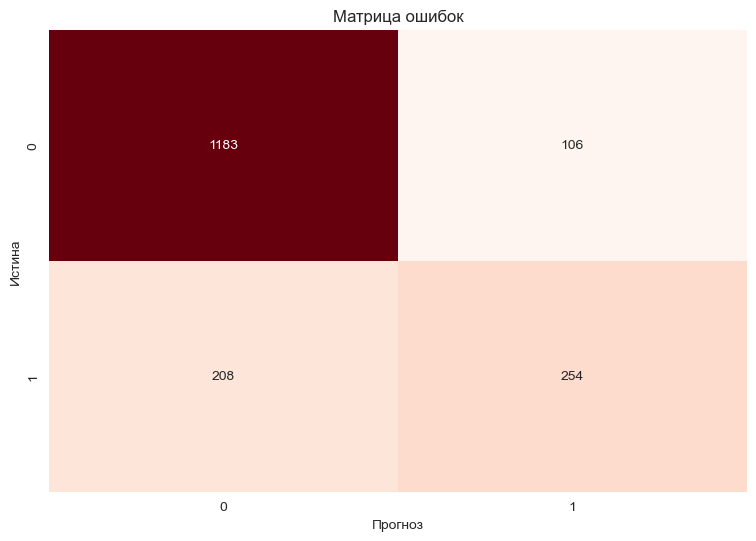

In [71]:
# создаём матрицу ошибок и сохраняем в переменную
matrix = confusion_matrix(np.array(y_test), preds)

# выводим график матрицы ошибок
plt.figure(figsize=(9, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Reds', cbar=False)
plt.xlabel('Прогноз')
plt.ylabel('Истина')
plt.title('Матрица ошибок')
plt.show()

`Вывод:` В данном графике есть четыре мерики:

- TP — истинно-положительные объекты ( True Positive ) = 1183 Это значит что предсказанные нелояльные абоненты, на практике, действительно таковыми являются (ушли от нас)
- FP — ложно-положительные объекты ( False Pasitive ) = 208 Это значит, что модель посчитала абонентов лояльными, но оказалось, что это не так и они ушли.
- TN — истинно-отрицательные объекты ( True Negative ) = 106 Это значит, что предсказнанные лояльные клиенты, действительно оказалить таковыми.
- FN — ложно-отрицательные объекты ( False Negative ) = 254 Это доля неверно предсказанных нелояльных абонентов.

Применительно к задаче выявления клиентов готовый прекратить пользоватся услугами оперетора, мы можем сделать вывод что модель хорошо справляется с предсказаниями и выявляет нелояльных аббонентов довольно эффективно, и редко ошибается.

## Полнота и точность модели

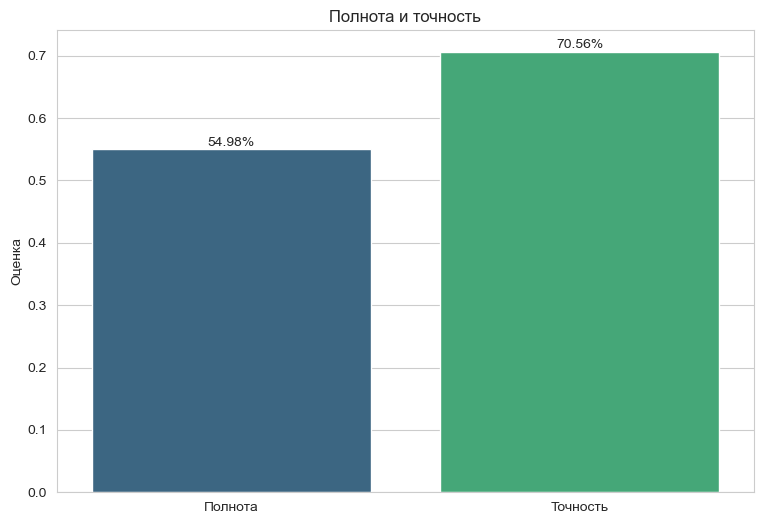

In [72]:
recall = recall_score(np.array(y_test), preds)
precision = precision_score(np.array(y_test), preds)

# создаём метки
labels = ['Полнота', 'Точность']
values = [recall, precision]

# создаём график
plt.figure(figsize=(9, 6))
bars = sns.barplot(x=labels, y=values, palette='viridis')
plt.title('Полнота и точность')
plt.ylabel('Оценка')
for bar in bars.patches:
    bars.annotate(f'{bar.get_height() * 100:.2f}%',
                  (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5), textcoords='offset points')
# выводим график
plt.show()

`Вывод:` 

Полнота: 90,57%

Точность: 84,13%

Полнота – какую долю ушедших клиентов  нам удалось выявить.

Точность — это количество правильных прогнозов, деленное на общее количество прогнозов, это то, насколько часто модель оказывается точной, когда она предсказывает положительный результат. низкая точность говорит о высоком уровне ложных срабатываний.


В нашем случае, оба показателя (Понтона и Точность) высокие. Это говорит о высоком качестве предсказаний.

## Анализиуем важость входных признаков

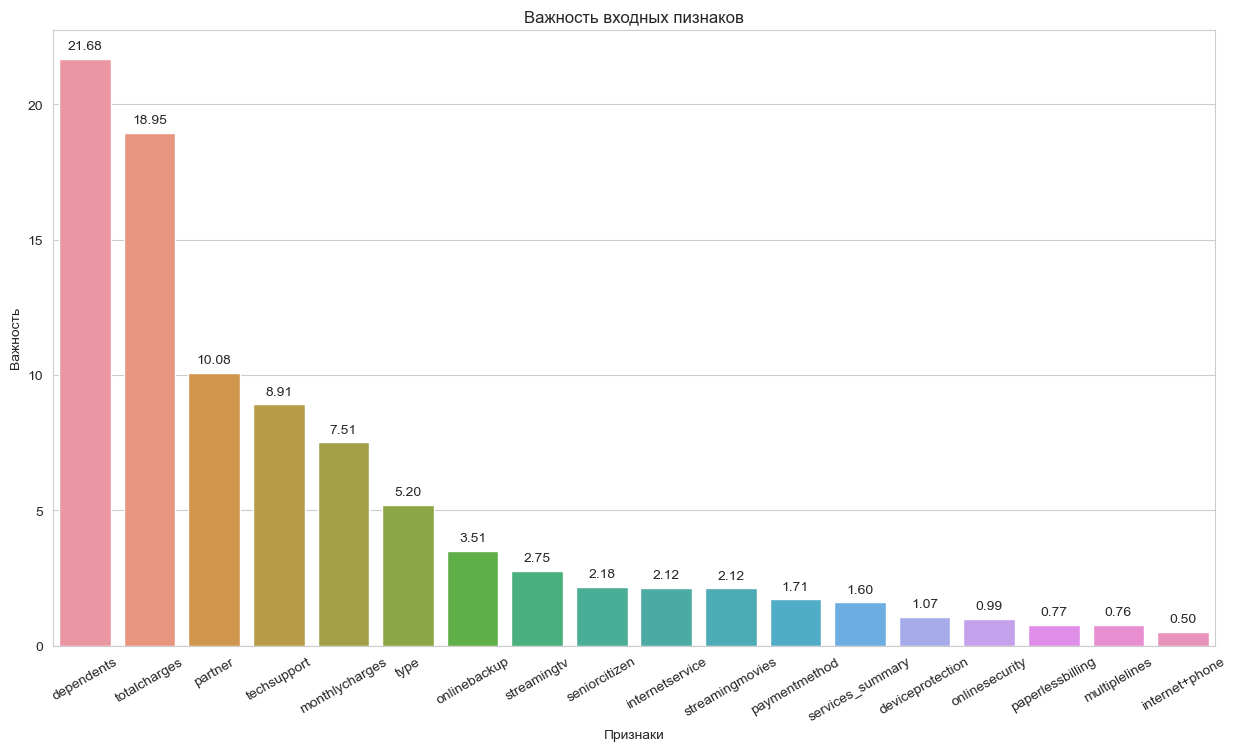

In [73]:
# Получение важности признаков из лучшей модели CatBoost
importances = best_cb.get_feature_importance()

# Получение названий признаков из тренировочных данных
features = x_train.columns

# Создание словаря, сопоставляющего имена признаков и их важности
importance_dict = {features[i]: importances[i] for i in range(len(features))}

# Сортировка признаков по важности в порядке убывания
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Построение столбчатой диаграммы для визуализации важности признаков
plt.figure(figsize=(15, 8))
bars = sns.barplot(x=[item[0] for item in sorted_importance], y=[item[1] for item in sorted_importance])
plt.title("Важность входных пизнаков")
plt.ylabel('Важность')
plt.xlabel('Признаки')
plt.xticks(rotation=90)

# Аннотирование каждого столбца его соответствующим значением важности
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 9),
                  textcoords='offset points')
# Дополнительный поворот меток по оси x для лучшей читаемости при необходимости    
plt.xticks(rotation=30)

# вывод графика
plt.show()

`Вывод:` самым важным признаком является наличие детей (dependents) у абонента.

## График зависимости входного и целевого признаков для признака dependents

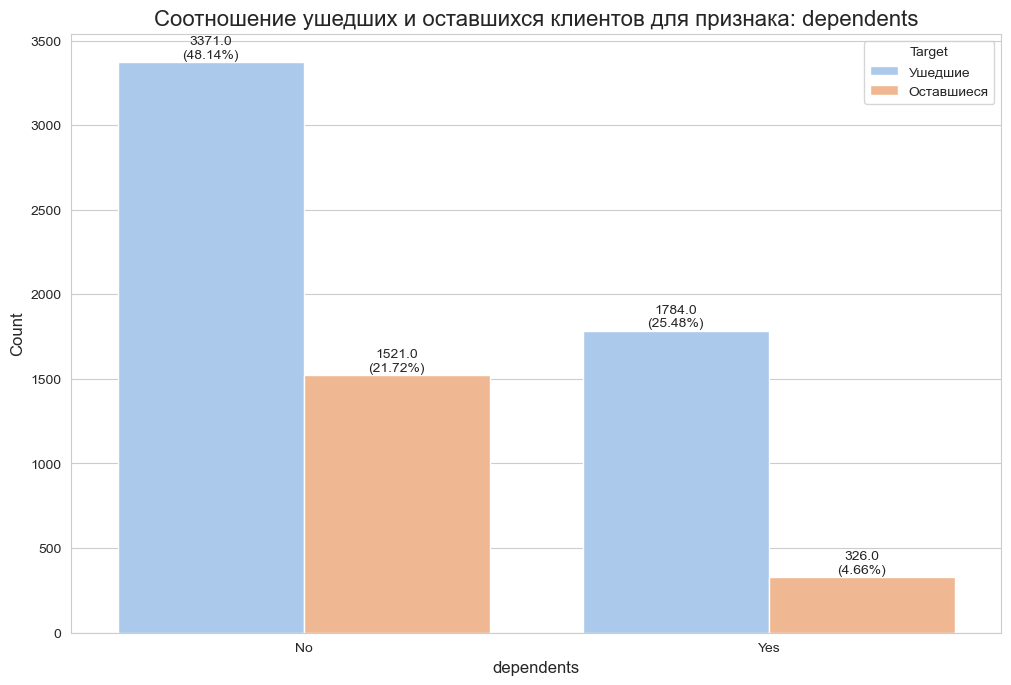

In [74]:
graph(final_df, 'dependents')

`Вывод:` мы видим на графике что оставшихся (лояльных) аббонентов с детьми значительно больше (пропорционально) чем у бездетных. 

# Общий вывод исследования

Целью нашего проэкта было составить модель, дающую достоверные прогнозы оттока клиентов телекоммуникационной компании "ТелеДом" с целью улучшения сервисов и сохранения клиентов.

В процессе работы, была проведена загрузка предобработка данных, включающая в себя создание новых признаков призванных улучшить работу модели обучения по средством нахождения новых закономерностей.

Для обучения были использованы три модели:

- Random Forest
- CatBoost
- Нейросеть

По результатам обучения, самой точной моделью оказалась модеть CatBoost.

Тестовая модель показала целевую метрику ROC-AUC: 0,8602
Accuracy: 0.80
Полнота: 90,57%
Точность: 84,13%


Рекомендации заказчику:

Рекомендую обратить внимание на первые пять категорий признако которые вносят значительный вклад в формирование лояльности клиентуры по отношению к компании.

Эти группы: клиенты с детьми, супругами, а также те кто вносим помесячную плату на услуги. Также стоит обратить внимание, что лояльность имеет сильную зависимость от суммы оплаты услуг и пользованием техподдержки которая положительно сказывается на ужержании клиентов. Возможно стоит расширить штат поддержки и сделать доступ к поддержке более интуитивно понятным, например, доработав мобильное приложение добавив туда чат поддержки.